# IMPORTS

In [1]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [152]:
def output_figure(f, direct, name):
    for ext in ['png', 'jpg', 'svg']:
        for res in [150, 300, 600]:
            f.savefig(direct + name + '_{}_DPI.{}'.format(res, ext), dpi=res)

In [134]:
utrs = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/UTRs_genes.parquet')
utrs

,Gene,CDS_ranges,5_prime_modif,3_prime_modif,Nb_combi
0,A1CF,"[52566489_52566640,52569654_52569802,52570800_...",8,0,4
1,A2M,"[9220419_9220435,9220779_9220820,9221336_92214...",3,0,3
2,A2ML1,"[8997768_8997770,8998038_8998098,8998673_89988...",0,0,2
3,A4GALT,"[43088896_43089957, 43088896_43089957]",2,2,1
4,AAAS,"[53701273_53701497,53701629_53701713,53701836_...",0,0,2
...,...,...,...,...,...
10932,ZWINT,"[58118179_58118220,58118317_58118448,58118670_...",2,3,2
10933,ZXDC,"[126180372_126181063,126184998_126185168,12618...",0,0,2
10934,ZYG11A,"[53308556_53308645,53320137_53320302,53322670_...",0,0,2
10935,ZYX,"[143078665_143078872,143079341_143079540,14307...",2,0,2


## mRNA distribution /gene + cumsum

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


          Gene  mRNA_nb
2          ADA        3
3         CDH2        2
4         AKT3        4
6         MED6        4
7        NR2E3        2
...        ...      ...
19315   PPP4R1        2
19316     CDH1        4
19317  SLC12A6        7
19318    PTBP3        6
19320    DGCR2        4

[9646 rows x 2 columns]
41729
          Gene  mRNA_nb
0          A2M        4
38       A2ML1        2
93        AACS        3
122      AADAT        2
135      AAGAB        3
...        ...      ...
176667  ZWILCH        2
176686   ZWINT        3
176698    ZXDC        2
176723     ZYX        3
176787    ZZZ3        2

[7225 rows x 2 columns]
27662


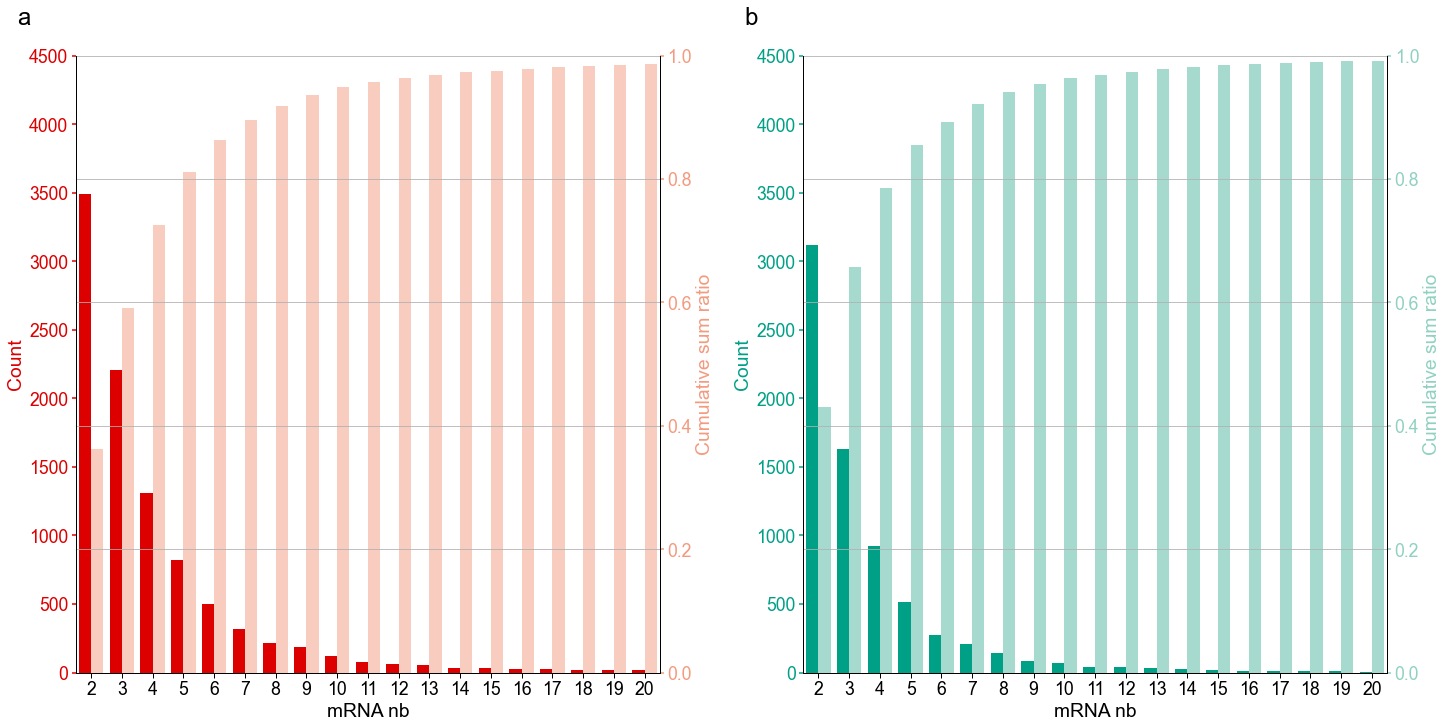

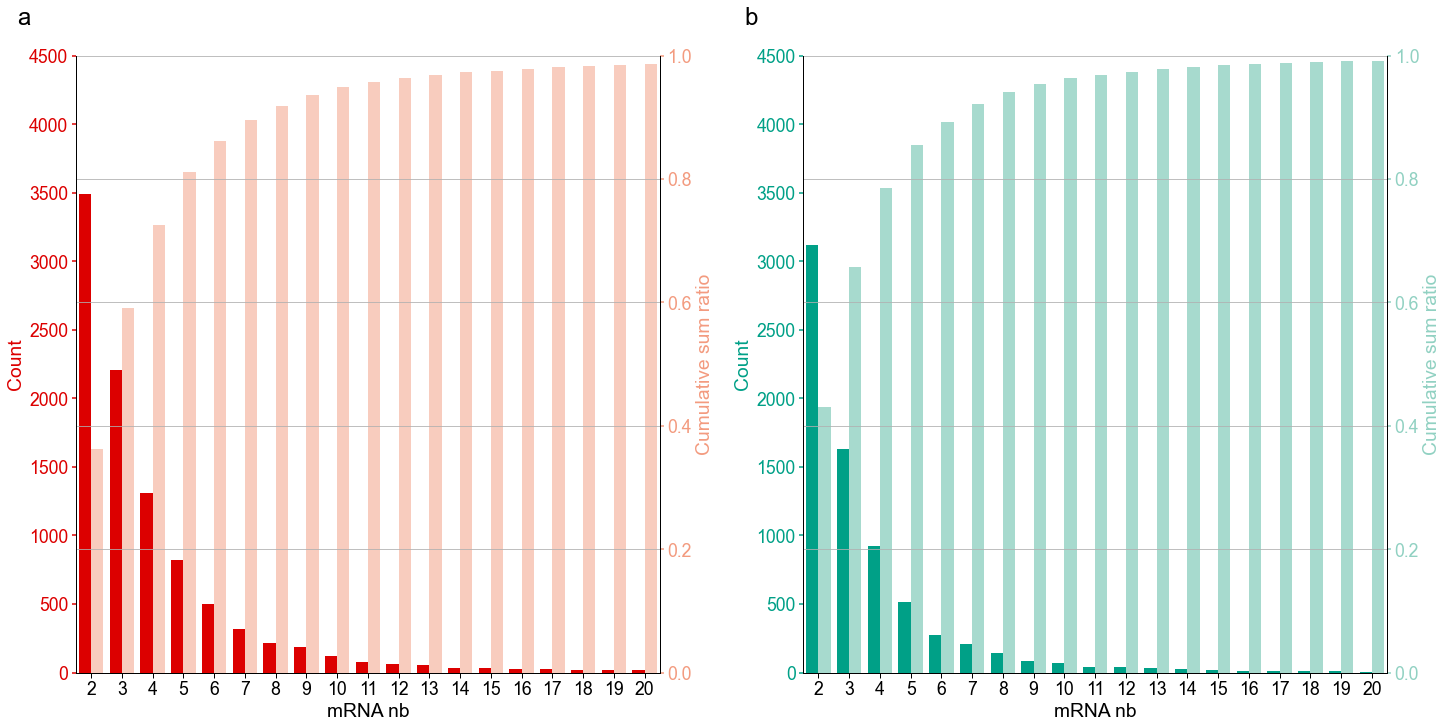

In [162]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'



color_aa = '#DC0000FF'
color_ab = '#F39B7FFF'
color_ba = '#00A087FF'
color_bb = '#91D1C2FF'


sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(ncols=2, figsize=(20,10), constrained_layout=True)



refseq_corrected_by_gtex = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/GRCh37_RefSeq_lite_hgnc.csv.gz', compression='gzip', sep='\t')
utrs = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/UTRs_genes.parquet')
utrs = utrs.loc[utrs['Nb_combi'] == 1]
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[~refseq_corrected_by_gtex['Name'].isin(utrs.Gene.unique().tolist())]
refseq_corrected_by_gtex['CDS_count'] = refseq_corrected_by_gtex['Count_CDS_alternative'] + refseq_corrected_by_gtex['Count_CDS_constitutive']
refseq_corrected_by_gtex = refseq_corrected_by_gtex.rename({'Name' : 'Gene'}, axis=1)
refseq_lite = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] > 1), ['Gene', 'mRNA_nb']].drop_duplicates()
refseq_lite.columns = ['Gene', 'mRNA_nb']
print(refseq_lite)
print(refseq_lite.mRNA_nb.sum())

# f, ax = plt.subplots(figsize=(10,10))
data = refseq_lite.groupby('mRNA_nb').size().reset_index()
cs = refseq_lite.groupby('mRNA_nb').size().cumsum() / refseq_lite.groupby('mRNA_nb').size().sum()
cs = cs.reset_index()
# ax.bar(x=[1,2,3], y=[2,3,4], )
ax1_ = ax[0].bar(data.mRNA_nb.values, data[0].values,
#        yerr=error,
       align='edge',
       alpha=1,
       color=color_aa,
       width=-0.4
#        ecolor='black',
#        color=list(reversed(sns.color_palette('mako'))),
#        color=sns.color_palette('YlOrBr'),
#        zorder=3,
#        **hfont
      )
ax2 = ax[0].twinx()
ax2_ = ax2.bar(cs.mRNA_nb.values, cs[0].values, alpha=0.5, color=color_ab, align='edge', width=0.4)
ax2.set_xlim(1.5,20.5)
ax[0].set_xticks(np.arange(2,21))

# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x, 0)))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax[0].yaxis.label.set_color(color_aa)
ax2.yaxis.label.set_color(color_ab)

tkw = dict(size=4, width=1.5)
ax[0].tick_params(axis='y', colors=color_aa, **tkw)
ax2.tick_params(axis='y', colors=color_ab, **tkw)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('mRNA nb')
ax2.set_ylabel('Cumulative sum ratio')
ax[0].spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax[0].set_ylim(0,4500)
ax2.set_ylim(0,1)
ax[0].text(-0.1, 1.05, 'a', transform=ax[0].transAxes, size=24, weight='bold')
# plt.subplots_adjust(hspace=5)
ax2.grid(axis='y')
# print(data[0].values, cs[0].values)



refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
utrs = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/UTRs_genes.parquet')


utrs = utrs.loc[utrs['Nb_combi'] == 1]
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[~refseq_corrected_by_gtex['Gene'].isin(utrs.Gene.unique().tolist())]
refseq_lite = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1) & (refseq_corrected_by_gtex['new_CDS_count'] > 1), ['Gene', 'new_mRNA_nb_total']].drop_duplicates()
refseq_lite.columns = ['Gene', 'mRNA_nb']
print(refseq_lite)
print(refseq_lite.mRNA_nb.sum())


data = refseq_lite.groupby('mRNA_nb').size().reset_index()
cs = refseq_lite.groupby('mRNA_nb').size().cumsum() / refseq_lite.groupby('mRNA_nb').size().sum()
cs = cs.reset_index()
# ax.bar(x=[1,2,3], y=[2,3,4], )
ax1_ = ax[1].bar(data.mRNA_nb.values, data[0].values,
#        yerr=error,
       align='edge',
       alpha=1,
       color=color_ba,
       width=-0.4
#        ecolor='black',
#        color=list(reversed(sns.color_palette('mako'))),
#        color=sns.color_palette('YlOrBr'),
#        zorder=3,
#        **hfont
      )
ax2 = ax[1].twinx()
ax2_ = ax2.bar(cs.mRNA_nb.values, cs[0].values, alpha=0.8, color=color_bb, align='edge', width=0.4)
ax2.set_xlim(1.5,20.5)
ax[1].set_xticks(np.arange(2,21))

# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x, 0)))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax[1].yaxis.label.set_color(color_ba)
ax2.yaxis.label.set_color(color_bb)

tkw = dict(size=4, width=1.5)
ax[1].tick_params(axis='y', colors=color_ba, **tkw)
ax2.tick_params(axis='y', colors=color_bb, **tkw)
ax[1].set_ylabel('Count')
ax[1].set_xlabel('mRNA nb')
ax2.set_ylabel('Cumulative sum ratio')
ax[1].spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax[1].set_ylim(0,4500)
ax2.set_ylim(0,1)
ax[1].text(-0.1, 1.05, 'b', transform=ax[1].transAxes, size=24, weight='bold')
ax2.grid(axis='y')


output_figure(f, "/gstock/EXOTIC/clean/FIGURES/1_ISOFORMS/", "Cumsum_mrnas")


f

In [157]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

refseq_corrected_by_gtex = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/GRCh37_RefSeq_lite_hgnc.csv.gz', compression='gzip', sep='\t')
utrs = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/UTRs_genes.parquet')
utrs = utrs.loc[utrs['Nb_combi'] == 1]
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[~refseq_corrected_by_gtex['Name'].isin(utrs.Gene.unique().tolist())]
refseq_corrected_by_gtex['CDS_count'] = refseq_corrected_by_gtex['Count_CDS_alternative'] + refseq_corrected_by_gtex['Count_CDS_constitutive']
refseq_corrected_by_gtex = refseq_corrected_by_gtex.rename({'Name' : 'Gene'}, axis=1)
refseq_lite = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] > 1), ['Gene', 'mRNA_nb']].drop_duplicates()
refseq_lite.columns = ['Gene', 'mRNA_nb']
print(refseq_lite)
print(refseq_lite.mRNA_nb.sum())

sns.set_context('paper', font_scale=2)
# f, ax = plt.subplots(figsize=(10,10))
data = refseq_lite.groupby('mRNA_nb').size().reset_index()
cs = refseq_lite.groupby('mRNA_nb').size().cumsum() / refseq_lite.groupby('mRNA_nb').size().sum()
cs = cs.reset_index()
# ax.bar(x=[1,2,3], y=[2,3,4], )
ax1_ = ax[0].bar(data.mRNA_nb.values, data[0].values,
#        yerr=error,
       align='edge',
       alpha=1,
       color="#DC0000",
       width=-0.4
#        ecolor='black',
#        color=list(reversed(sns.color_palette('mako'))),
#        color=sns.color_palette('YlOrBr'),
#        zorder=3,
#        **hfont
      )
ax2 = ax[0].twinx()
ax2_ = ax2.bar(cs.mRNA_nb.values, cs[0].values, alpha=0.5, color='#F39B7F', align='edge', width=0.4)
ax2.set_xlim(1.5,20.5)
ax[0].set_xticks(np.arange(2,21))

# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x, 0)))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax[0].yaxis.label.set_color("#DC0000")
ax2.yaxis.label.set_color('#F39B7F')

tkw = dict(size=4, width=1.5)
ax[0].tick_params(axis='y', colors='#DC0000', **tkw)
ax2.tick_params(axis='y', colors='#F39B7F', **tkw)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('mRNA nb')
ax2.set_ylabel('Cumulative sum ratio')
ax[0].spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax[0].set_ylim(0,4500)
ax2.set_ylim(0,1)
ax[0].text(-0.1, 1.05, 'a', transform=ax[0].transAxes, size=24, weight='bold')
# plt.subplots_adjust(hspace=5)
ax2.grid(axis='y')
print(data[0].values, cs[0].values)
# output_figure(f, "/gstock/EXOTIC/clean/FIGURES/1_ISOFORMS/", "Cumsum_mrnas")
f

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


          Gene  mRNA_nb
2          ADA        3
3         CDH2        2
4         AKT3        4
6         MED6        4
7        NR2E3        2
...        ...      ...
19315   PPP4R1        2
19316     CDH1        4
19317  SLC12A6        7
19318    PTBP3        6
19320    DGCR2        4

[9646 rows x 2 columns]
41729
[3488 2207 1306  821  497  318  215  183  121   76   63   54   34   30
   29   28   18   16   16   16   12   10    2    6    7   12    7    3
    4    9    2    6    3    1    5    1    1    3    2    1    1    2
    1    1    1    1    1    1    1    1    1    1] [0.36160066 0.59040017 0.72579307 0.81090608 0.86243002 0.89539706
 0.91768609 0.93665768 0.94920174 0.95708066 0.96361186 0.96921004
 0.97273481 0.97584491 0.97885134 0.98175409 0.98362015 0.98527887
 0.98693759 0.98859631 0.98984035 0.99087705 0.99108439 0.99170641
 0.9924321  0.99367614 0.99440182 0.99471283 0.99512751 0.99606054
 0.99626788 0.9968899  0.99720091 0.99730458 0.99782293 0.9979266
 0.99803027 0.9

KeyboardInterrupt: 

In [24]:
ax[1]

In [51]:
refseq_corrected_by_gtex = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/DF_transformed.csv.gz', compression='gzip', sep='\t')
refseq_corrected_by_gtex

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene,Chrom,Start,End,ranges,Length,GeneID,HGNC,CDS_representation,Ratio,Sharing_status,Sources,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,mRNA_nb
0,OR4F5,1,69091,70008,69091-70008,917,79501,14825.0,Unique,1.0/1,False,"[(69091, 70008, '1.0/1')]",0,1,['NM_001005484.1'],1
1,OR4F29,1,367659,368597,367659-368597,938,729759,31275.0,Unique,1.0/1,False,"[(367659, 368597, '1.0/1')]",0,1,['NM_001005221.2'],1
2,OR4F16,1,621096,622034,621096-622034,938,81399,15079.0,Unique,1.0/1,False,"[(621096, 622034, '1.0/1')]",0,1,['NM_001005277.1'],1
3,SAMD11,1,861322,861393,861322-861393,71,148398,28706.0,Unique,1.0/1,False,"[(861322, 861393, '1.0/1')]",0,13,['NM_152486.3'],1
4,SAMD11,1,865535,865716,865535-865716,181,148398,28706.0,Unique,1.0/1,False,"[(865535, 865716, '1.0/1')]",0,13,['NM_152486.3'],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238564,CDY1,Y,27768590,27770181,27768590-27770181,1591,9085,1809.0,Variable_region,2.0/2,True,"[(27768590, 27770181, '1.0/2'), (27768590, 277...",2,1,"['NM_004680.2', 'NM_170723.1']",2
238565,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2
238566,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2
238567,CDY1,Y,27770602,27770674,27770602-27770674,72,9085,1809.0,Unique,1.0/2,False,"[(27770602, 27770674, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2


In [59]:
refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] > 1)].drop_duplicates(subset=['ranges'])

,Gene,Chrom,Start,End,ranges,Length,GeneID,HGNC,CDS_representation,Ratio,Sharing_status,Sources,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,mRNA_nb,CDS_count,Ratio_num,Const_Alt,Ratio_num_bins
47,PLEKHN1,1,901912,901994,901912-901994,82,84069,25284.0,Unique,3.0/3,False,"[(901912, 901994, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,"(0.8, 1.0]"
48,PLEKHN1,1,902084,902183,902084-902183,99,84069,25284.0,Unique,3.0/3,False,"[(902084, 902183, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,"(0.8, 1.0]"
49,PLEKHN1,1,905657,905803,905657-905803,146,84069,25284.0,Unique,3.0/3,False,"[(905657, 905803, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,"(0.8, 1.0]"
50,PLEKHN1,1,905901,905981,905901-905981,80,84069,25284.0,Unique,3.0/3,False,"[(905901, 905981, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,"(0.8, 1.0]"
51,PLEKHN1,1,906066,906138,906066-906138,72,84069,25284.0,Unique,3.0/3,False,"[(906066, 906138, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,"(0.8, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238564,CDY1,Y,27768590,27770181,27768590-27770181,1591,9085,1809.0,Variable_region,2.0/2,True,"[(27768590, 27770181, '1.0/2'), (27768590, 277...",2,1,"['NM_004680.2', 'NM_170723.1']",2,3,1.0,Const,"(0.8, 1.0]"
238565,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,3,0.5,Alt,"(0.4, 0.6]"
238566,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,3,0.5,Alt,"(0.4, 0.6]"
238567,CDY1,Y,27770602,27770674,27770602-27770674,72,9085,1809.0,Unique,1.0/2,False,"[(27770602, 27770674, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,3,0.5,Alt,"(0.4, 0.6]"


In [166]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

refseq_corrected_by_gtex = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/DF_transformed.csv.gz', compression='gzip', sep='\t')

utrs = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/UTRs_genes.parquet')
utrs = utrs.loc[utrs['Nb_combi'] == 1]
# refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[~refseq_corrected_by_gtex['Gene'].isin(utrs.Gene.unique().tolist())]

refseq_corrected_by_gtex['CDS_count'] = refseq_corrected_by_gtex['Count_CDS_alternative'] + refseq_corrected_by_gtex['Count_CDS_constitutive']

refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] >= 1)].drop_duplicates(subset=['ranges'])

refseq_corrected_by_gtex['Ratio_num'] = refseq_corrected_by_gtex['Ratio'].apply(eval)
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Ratio_num'] == 1, 'Const_Alt'] = 'Const'
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Ratio_num'] < 1, 'Const_Alt'] = 'Alt'
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] > 1)]
refseq_corrected_by_gtex.columns = [c.replace('new_', '') for c in refseq_corrected_by_gtex.columns]

refseq_corrected_by_gtex['Ratio_num_bins'] = pd.cut(refseq_corrected_by_gtex['Ratio_num'], [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1.0'])

refseq_corrected_by_gtex

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene,Chrom,Start,End,ranges,Length,GeneID,HGNC,CDS_representation,Ratio,Sharing_status,Sources,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,mRNA_nb,CDS_count,Ratio_num,Const_Alt,Ratio_num_bins
47,PLEKHN1,1,901912,901994,901912-901994,82,84069,25284.0,Unique,3.0/3,False,"[(901912, 901994, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,0.8 - 1.0
48,PLEKHN1,1,902084,902183,902084-902183,99,84069,25284.0,Unique,3.0/3,False,"[(902084, 902183, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,0.8 - 1.0
49,PLEKHN1,1,905657,905803,905657-905803,146,84069,25284.0,Unique,3.0/3,False,"[(905657, 905803, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,0.8 - 1.0
50,PLEKHN1,1,905901,905981,905901-905981,80,84069,25284.0,Unique,3.0/3,False,"[(905901, 905981, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,0.8 - 1.0
51,PLEKHN1,1,906066,906138,906066-906138,72,84069,25284.0,Unique,3.0/3,False,"[(906066, 906138, '3.0/3')]",2,15,"['NM_001367552.1', 'NM_001160184.2', 'NM_03212...",3,17,1.0,Const,0.8 - 1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238547,DAZ4,Y,27042652,27042686,27042652-27042686,34,57135,15966.0,Unique,2.0/2,False,"[(27042652, 27042686, '2.0/2')]",6,16,"['NM_001005375.2', 'NM_020420.3']",2,22,1.0,Const,0.8 - 1.0
238549,DAZ4,Y,27047259,27047322,27047259-27047322,63,57135,15966.0,Unique,2.0/2,False,"[(27047259, 27047322, '2.0/2')]",6,16,"['NM_001005375.2', 'NM_020420.3']",2,22,1.0,Const,0.8 - 1.0
238563,CDY1,Y,27768590,27770181,27768590-27770181,1591,9085,1809.0,Variable_region,2.0/2,True,"[(27768590, 27770181, '1.0/2'), (27768590, 277...",2,1,"['NM_004680.2', 'NM_170723.1']",2,3,1.0,Const,0.8 - 1.0
238565,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,3,0.5,Alt,0.4 - 0.6


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rectangle(xy=(-0.15, 0), width=0.3, height=85297, angle=0)
Rectangle(xy=(0.85, 0), width=0.3, height=50682, angle=0)
Rectangle(xy=(-0.25, 0), width=0.5, height=4583, angle=0)
Rectangle(xy=(0.75, 0), width=0.5, height=9697, angle=0)
Rectangle(xy=(1.75, 0), width=0.5, height=16320, angle=0)
Rectangle(xy=(2.75, 0), width=0.5, height=15261, angle=0)
Rectangle(xy=(3.75, 0), width=0.5, height=4821, angle=0)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Const v.s. Alt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=2.757e+09
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Const v.s. Alt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=6.283e+07


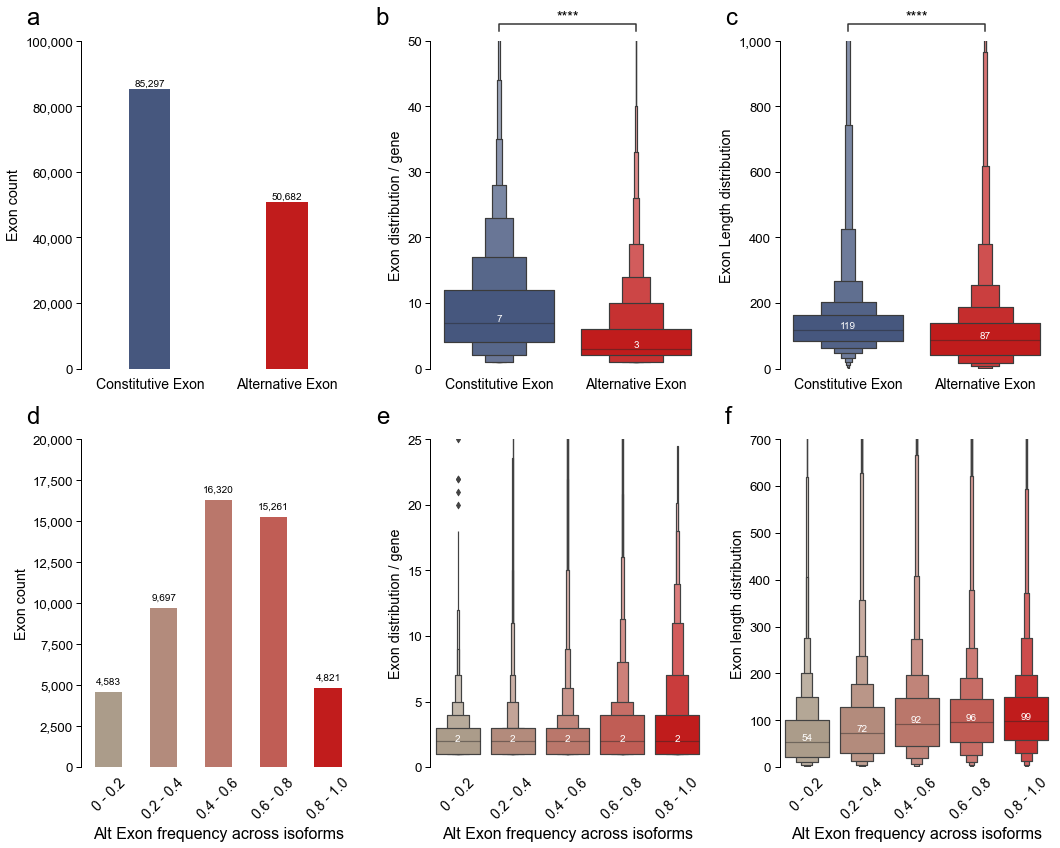

In [170]:

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

refseq_corrected_by_gtex = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/DF_transformed.csv.gz', compression='gzip', sep='\t')

utrs = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/UTRs_genes.parquet')
utrs = utrs.loc[utrs['Nb_combi'] == 1]
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[~refseq_corrected_by_gtex['Gene'].isin(utrs.Gene.unique().tolist())]

refseq_corrected_by_gtex['CDS_count'] = refseq_corrected_by_gtex['Count_CDS_alternative'] + refseq_corrected_by_gtex['Count_CDS_constitutive']

refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] >= 1)].drop_duplicates(subset=['ranges'])

refseq_corrected_by_gtex['Ratio_num'] = refseq_corrected_by_gtex['Ratio'].apply(eval)
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Ratio_num'] == 1, 'Const_Alt'] = 'Const'
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Ratio_num'] < 1, 'Const_Alt'] = 'Alt'
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] > 1)]
refseq_corrected_by_gtex.columns = [c.replace('new_', '') for c in refseq_corrected_by_gtex.columns]

refseq_corrected_by_gtex['Ratio_num_bins'] = pd.cut(refseq_corrected_by_gtex['Ratio_num'], [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1.0'])

refseq_corrected_by_gtex

def show_values_on_bars(axs, i=0, fontsize=10, rotation=0, color='black', pad=10):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width()/2 
            _y = p.get_y() + (p.get_height()) + pad
            if i == 0:
                value = "{:,.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color=color)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
fontsize_top_row_ticks = 14
fontsize_bottom_row_labels = 16
        
sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
t = refseq_corrected_by_gtex.groupby('Const_Alt').size().reset_index()
f1 = sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), x='Const_Alt', y=0, ax=ax[0][0], palette=['#3C548899', '#DC000099'] )
widthbars = [0.3, 0.3]
for bar, newwidth in zip(f1.patches, widthbars):
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
    
f1.set_ylim(0, 100000)
ax[0][0].spines['bottom'].set_linewidth(0)
ax[0][0].spines['right'].set_linewidth(0)
ax[0][0].spines['top'].set_linewidth(0)
ax[0][0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel('Exon count')
ax[0][0].set_xticklabels(['Constitutive Exon', 'Alternative Exon'], fontsize=fontsize_top_row_ticks)
ax[0][0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
show_values_on_bars(ax[0][0], i=0, pad=1000)

f2 = sns.boxenplot(data=refseq_corrected_by_gtex[['Const_Alt', 'Length']], x='Const_Alt', y='Length', ax=ax[0][2], palette=['#3C548899', '#DC000099'])

medians = refseq_corrected_by_gtex[['Const_Alt', 'Length']].groupby(['Const_Alt'])['Length'].median().sort_index(ascending=False)
vertical_offset = refseq_corrected_by_gtex['Length'].median() * 0.05 # offset from median for display


for xtick in f2.get_xticks():
    f2.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')


ax[0][2].spines['bottom'].set_linewidth(0)
ax[0][2].spines['right'].set_linewidth(0)
ax[0][2].spines['top'].set_linewidth(0)
ax[0][2].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][2].set_xlabel('')
ax[0][2].set_ylabel('Exon Length distribution')
ax[0][2].set_xticklabels(['Constitutive Exon', 'Alternative Exon'], fontsize=fontsize_top_row_ticks)
ax[0][2].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


f2.set_ylim(0, 1000)

t = refseq_corrected_by_gtex[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index()
t = t.sort_values(by='Const_Alt', ascending=False)
t

f3 = sns.boxenplot(data=t, x='Const_Alt', y=0, ax=ax[0][1], palette=['#3C5488FF', '#DC000099'])

medians = refseq_corrected_by_gtex[['Const_Alt', 'Gene']].groupby(['Gene', 'Const_Alt']).size().reset_index().pivot(columns='Const_Alt', values=0, index='Gene').median().sort_index(ascending=False)
vertical_offset = refseq_corrected_by_gtex[['Const_Alt', 'Gene']].groupby(['Gene', 'Const_Alt']).size().reset_index().median() * 0.05 # offset from median for display
vertical_offset

for xtick in f3.get_xticks():
    f3.text(xtick,medians[xtick] + vertical_offset,int(medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')



ax[0][1].spines['bottom'].set_linewidth(0)
ax[0][1].spines['right'].set_linewidth(0)
ax[0][1].spines['top'].set_linewidth(0)
ax[0][1].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('Exon distribution / gene')
ax[0][1].set_xticklabels(['Constitutive Exon', 'Alternative Exon'], fontsize=fontsize_top_row_ticks)

f3.set_ylim(0, 50)

t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Ratio_num_bins']].groupby('Ratio_num_bins').size().reset_index()
t = t.sort_values(by='Ratio_num_bins', ascending=False)
f4 = sns.barplot(data=t, x='Ratio_num_bins', y=0, ax=ax[1][0], palette=['#b09c85', '#bc8773', '#c76e5e', '#d24e43', '#dc0000'])
widthbars = [0.5, 0.5, 0.5, 0.5, 0.5]
for bar, newwidth in zip(f4.patches, widthbars):
    x = bar.get_x() 
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
    
ax[1][0].spines['bottom'].set_linewidth(0)
ax[1][0].spines['right'].set_linewidth(0)
ax[1][0].spines['top'].set_linewidth(0)
ax[1][0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][0].set_xlabel('Alt Exon frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][0].set_ylabel('Exon count')
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
ax[1][0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

f4.set_ylim(0, 20000)
show_values_on_bars(ax[1][0], i=0, pad=500)



t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
t = t.loc[t[0] > 0].sort_values(by='Ratio_num_bins', ascending=True)
medians = t.groupby('Ratio_num_bins')[0].median().sort_index(ascending=True)

f5 = sns.boxenplot(data=t, x='Ratio_num_bins', y=0, ax=ax[1][1], palette=['#b09c85', '#bc8773', '#c76e5e', '#d24e43', '#dc0000'])

# medians = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index().pivot(columns='Ratio_num_bins', values=0, index='Gene').median().sort_index(ascending=False)
vertical_offset = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index().median() * 0.05 # offset from median for display
vertical_offset

for j, xtick in enumerate(f5.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    f5.text(xtick,medians[xtick] + vertical_offset,int(medians[xtick]), 
            horizontalalignment='center',size='x-small',color=color,weight='semibold')



ax[1][1].spines['bottom'].set_linewidth(0)
ax[1][1].spines['right'].set_linewidth(0)
ax[1][1].spines['top'].set_linewidth(0)
ax[1][1].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][1].set_xlabel('Alt Exon frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][1].set_ylabel('Exon distribution / gene')
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
f5.set_ylim(0, 25)



t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins', 'Length']]
t = t.sort_values(by='Ratio_num_bins', ascending=True)
f6 = sns.boxenplot(data=t, x='Ratio_num_bins', y='Length', ax=ax[1][2], palette=['#b09c85', '#bc8773', '#c76e5e', '#d24e43', '#dc0000'])


medians = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins', 'Length']].groupby(['Ratio_num_bins'])['Length'].median().sort_index(ascending=True)
vertical_offset = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Length']].median() * 0.05 # offset from median for display


for j, xtick in enumerate(f6.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    f6.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color=color,weight='semibold')

ax[1][2].spines['bottom'].set_linewidth(0)
ax[1][2].spines['right'].set_linewidth(0)
ax[1][2].spines['top'].set_linewidth(0)
ax[1][2].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][2].set_xlabel('Alt Exon frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][2].set_ylabel('Exon length distribution')
ax[1][2].set_xticklabels(ax[1][2].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
f6.set_ylim(0, 700)

axs = ax.flat
import string

for n, a in enumerate(axs):
    a.text(-0.2, 1.05, string.ascii_lowercase[n], transform=a.transAxes, size=24, weight='bold')

plt.tight_layout()
add_stat_annotation(f2, data=refseq_corrected_by_gtex, x='Const_Alt', y='Length', order= ['Const', 'Alt'],
                    box_pairs=[('Const', 'Alt')],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

t = refseq_corrected_by_gtex[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index()

add_stat_annotation(f3, data=t, x='Const_Alt', y=0, order= ['Const', 'Alt'],
                    box_pairs=[('Const', 'Alt')],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

# t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
# add_stat_annotation(f6, data=t, x='Ratio_num_bins', y=0, order= t.Ratio_num_bins.cat.categories,
#                     box_pairs=[('0 - 0.2', '0.8 - 1'), ('0 - 0.2', '0.2 - 0.4')],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
output_figure(f, "/gstock/EXOTIC/clean/FIGURES/1_ISOFORMS/", 'Exons_before_correction')

In [66]:
t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
t = t.sort_values(by='Ratio_num_bins', ascending=True)
t

,Gene,Ratio_num_bins,0
0,A2M,0 - 0.2,0
29070,SYT17,0 - 0.2,0
22190,POLR1E,0 - 0.2,0
6120,CLASP2,0 - 0.2,0
29075,SYT5,0 - 0.2,0
...,...,...,...
22189,POLR1D,0.8 - 1,0
13004,HMOX2,0.8 - 1,0
6124,CLASP2,0.8 - 1,0
22159,POLH,0.8 - 1,0


In [118]:
refseq_corrected_by_gtex = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/DF_transformed.csv.gz', compression='gzip', sep='\t')
refseq_corrected_by_gtex['CDS_count'] = refseq_corrected_by_gtex['Count_CDS_alternative'] + refseq_corrected_by_gtex['Count_CDS_constitutive']
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] >= 1)].drop_duplicates(subset=['ranges'])
refseq_corrected_by_gtex['Ratio_num'] = refseq_corrected_by_gtex['Ratio'].apply(eval)
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Ratio_num'] == 1, 'Const_Alt'] = 'Const'
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Ratio_num'] < 1, 'Const_Alt'] = 'Alt'
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['mRNA_nb'] > 1) & (refseq_corrected_by_gtex['CDS_count'] > 1)]
refseq_corrected_by_gtex['Ratio_num_bins'] = pd.cut(refseq_corrected_by_gtex['Ratio_num'], [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1.0'], include_lowest=True)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().groupby('Ratio_num_bins').count()

Ratio_num_bins
0 - 0.2      9631
0.2 - 0.4    9631
0.4 - 0.6    9631
0.6 - 0.8    9631
0.8 - 1.0    9631
dtype: int64

In [121]:
t =  refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
t.loc[t[0] > 0].groupby('Ratio_num_bins').median()

,0
Ratio_num_bins,
0 - 0.2,2
0.2 - 0.4,2
0.4 - 0.6,2
0.6 - 0.8,2
0.8 - 1.0,2


In [112]:
refseq_corrected_by_gtex[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index().groupby('Const_Alt').mean()

,0
Const_Alt,
Alt,5.618270
Const,8.844061


In [97]:
refseq_corrected_by_gtex[['Gene', 'Const_Alt', 'Ratio_num_bins']]

,Gene,Const_Alt,Ratio_num_bins
47,PLEKHN1,Const,0.8 - 1.0
48,PLEKHN1,Const,0.8 - 1.0
49,PLEKHN1,Const,0.8 - 1.0
50,PLEKHN1,Const,0.8 - 1.0
51,PLEKHN1,Const,0.8 - 1.0
...,...,...,...
238547,DAZ4,Const,0.8 - 1.0
238549,DAZ4,Const,0.8 - 1.0
238563,CDY1,Const,0.8 - 1.0
238565,CDY1,Alt,0.4 - 0.6


In [127]:
t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
medians = t.loc[t[0] > 0].sort_values(by='Ratio_num_bins', ascending=False).groupby('Ratio_num_bins')[0].median()
t

Ratio_num_bins
0 - 0.2      3
0.2 - 0.4    2
0.4 - 0.6    2
0.6 - 0.8    2
0.8 - 1      2
Name: 0, dtype: int64

In [172]:
refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
refseq_corrected_by_gtex

,Gene,ranges,new_mRNA_exons,new_mRNA_nb,new_mRNA_gene,new_mRNA_nb_total,new_Ratio,new_Ratio_num,Const_Alt,new_Ratio_num_bins,Start,End,Length,new_CDS_count
0,A2M,9220419-9220435,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220419,9220435,16,38
1,A2M,9220779-9220820,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220779,9220820,41,38
2,A2M,9221336-9221438,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9221336,9221438,102,38
3,A2M,9222341-9222409,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9222341,9222409,68,38
4,A2M,9223084-9223174,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9223084,9223174,90,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176794,ZZZ3,78047461-78047576,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78047461,78047576,115,12
176795,ZZZ3,78047664-78047811,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78047664,78047811,147,12
176796,ZZZ3,78050202-78050340,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78050202,78050340,138,12
176797,ZZZ3,78097535-78099039,[NM_015534],1,"[NM_001308237, NM_015534]",2,1/2,0.5,Alt,0.4 - 0.6,78097535,78099039,1504,12


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


Rectangle(xy=(-0.15, 0), width=0.3, height=66640, angle=0)
Rectangle(xy=(0.85, 0), width=0.3, height=39547, angle=0)
Rectangle(xy=(-0.25, 0), width=0.5, height=4109, angle=0)
Rectangle(xy=(0.75, 0), width=0.5, height=8968, angle=0)
Rectangle(xy=(1.75, 0), width=0.5, height=14783, angle=0)
Rectangle(xy=(2.75, 0), width=0.5, height=9642, angle=0)
Rectangle(xy=(3.75, 0), width=0.5, height=2045, angle=0)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Const v.s. Alt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.097e-116 U_stat=1.429e+09


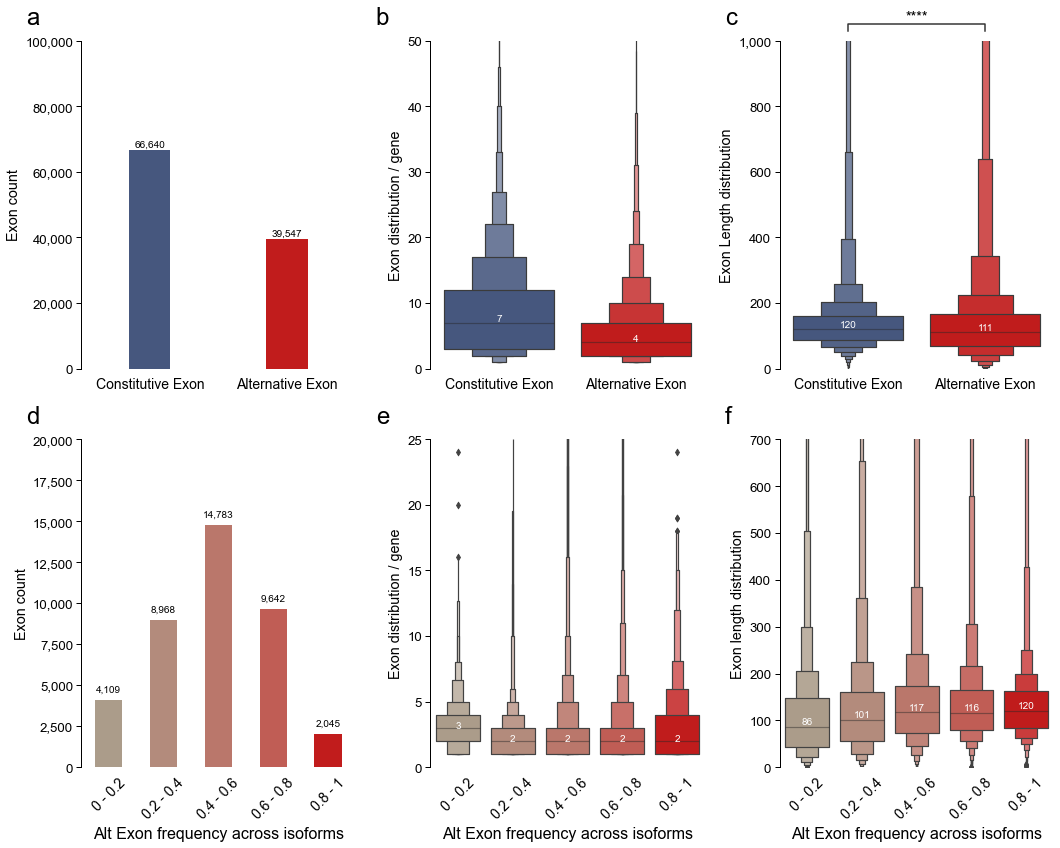

In [171]:

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
refseq_corrected_by_gtex = refseq_corrected_by_gtex.loc[(refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1) & (refseq_corrected_by_gtex['new_CDS_count'] > 1)]
refseq_corrected_by_gtex.columns = [c.replace('new_', '') for c in refseq_corrected_by_gtex.columns]

def show_values_on_bars(axs, i=0, fontsize=10, rotation=0, color='black', pad=10):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width()/2 
            _y = p.get_y() + (p.get_height()) + pad
            if i == 0:
                value = "{:,.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color=color)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
fontsize_top_row_ticks = 14
fontsize_bottom_row_labels = 16
        
sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
t = refseq_corrected_by_gtex.groupby('Const_Alt').size().reset_index()
f1 = sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), x='Const_Alt', y=0, ax=ax[0][0], palette=['#3C548899', '#DC000099'] )
widthbars = [0.3, 0.3]
for bar, newwidth in zip(f1.patches, widthbars):
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
    
f1.set_ylim(0, 100000)
ax[0][0].spines['bottom'].set_linewidth(0)
ax[0][0].spines['right'].set_linewidth(0)
ax[0][0].spines['top'].set_linewidth(0)
ax[0][0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel('Exon count')
ax[0][0].set_xticklabels(['Constitutive Exon', 'Alternative Exon'], fontsize=fontsize_top_row_ticks)
ax[0][0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
show_values_on_bars(ax[0][0], i=0, pad=1000)

f2 = sns.boxenplot(data=refseq_corrected_by_gtex[['Const_Alt', 'Length']], x='Const_Alt', y='Length', ax=ax[0][2], palette=['#3C548899', '#DC000099'])

medians = refseq_corrected_by_gtex[['Const_Alt', 'Length']].groupby(['Const_Alt'])['Length'].median().sort_index(ascending=False)
vertical_offset = refseq_corrected_by_gtex['Length'].median() * 0.05 # offset from median for display


for xtick in f2.get_xticks():
    f2.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')


ax[0][2].spines['bottom'].set_linewidth(0)
ax[0][2].spines['right'].set_linewidth(0)
ax[0][2].spines['top'].set_linewidth(0)
ax[0][2].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][2].set_xlabel('')
ax[0][2].set_ylabel('Exon Length distribution')
ax[0][2].set_xticklabels(['Constitutive Exon', 'Alternative Exon'], fontsize=fontsize_top_row_ticks)
ax[0][2].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


f2.set_ylim(0, 1000)


t = refseq_corrected_by_gtex[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index()
t = t.sort_values(by='Const_Alt', ascending=False)
t

f3 = sns.boxenplot(data=t, x='Const_Alt', y=0, ax=ax[0][1], palette=['#3C5488FF', '#DC000099'])

medians = refseq_corrected_by_gtex[['Const_Alt', 'Gene']].groupby(['Gene', 'Const_Alt']).size().reset_index().pivot(columns='Const_Alt', values=0, index='Gene').median().sort_index(ascending=False)
vertical_offset = refseq_corrected_by_gtex[['Const_Alt', 'Gene']].groupby(['Gene', 'Const_Alt']).size().reset_index().median() * 0.05 # offset from median for display
vertical_offset

for xtick in f3.get_xticks():
    f3.text(xtick,medians[xtick] + vertical_offset,int(medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')



ax[0][1].spines['bottom'].set_linewidth(0)
ax[0][1].spines['right'].set_linewidth(0)
ax[0][1].spines['top'].set_linewidth(0)
ax[0][1].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('Exon distribution / gene')
ax[0][1].set_xticklabels(['Constitutive Exon', 'Alternative Exon'], fontsize=fontsize_top_row_ticks)

f3.set_ylim(0, 50)

t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Ratio_num_bins']].groupby('Ratio_num_bins').size().reset_index()
t = t.sort_values(by='Ratio_num_bins', ascending=False)
f4 = sns.barplot(data=t, x='Ratio_num_bins', y=0, ax=ax[1][0], palette=['#b09c85', '#bc8773', '#c76e5e', '#d24e43', '#dc0000'])
widthbars = [0.5, 0.5, 0.5, 0.5, 0.5]
for bar, newwidth in zip(f4.patches, widthbars):
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
    
ax[1][0].spines['bottom'].set_linewidth(0)
ax[1][0].spines['right'].set_linewidth(0)
ax[1][0].spines['top'].set_linewidth(0)
ax[1][0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][0].set_xlabel('Alt Exon frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][0].set_ylabel('Exon count')
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
ax[1][0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

f4.set_ylim(0, 20000)
show_values_on_bars(ax[1][0], i=0, pad=500)



# t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
t = t.loc[t[0] > 0].sort_values(by='Ratio_num_bins', ascending=False)
medians = t.groupby('Ratio_num_bins')[0].median().sort_index(ascending=True)

f5 = sns.boxenplot(data=t, x='Ratio_num_bins', y=0, ax=ax[1][1], palette=['#b09c85', '#bc8773', '#c76e5e', '#d24e43', '#dc0000'])

# medians = t.groupby().median().sort_index(ascending=False)
vertical_offset = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index().median() * 0.05 # offset from median for display
vertical_offset

for j, xtick in enumerate(f5.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    f5.text(xtick,medians[xtick] + vertical_offset,int(medians[xtick]), 
            horizontalalignment='center',size='x-small',color=color,weight='semibold')



ax[1][1].spines['bottom'].set_linewidth(0)
ax[1][1].spines['right'].set_linewidth(0)
ax[1][1].spines['top'].set_linewidth(0)
ax[1][1].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][1].set_xlabel('Alt Exon frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][1].set_ylabel('Exon distribution / gene')
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
f5.set_ylim(0, 25)



t = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins', 'Length']]
t = t.sort_values(by='Ratio_num_bins', ascending=False)
f6 = sns.boxenplot(data=t, x='Ratio_num_bins', y='Length', ax=ax[1][2], palette=['#b09c85', '#bc8773', '#c76e5e', '#d24e43', '#dc0000'])


medians = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins', 'Length']].groupby(['Ratio_num_bins'])['Length'].median().sort_index(ascending=True)
vertical_offset = refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['Const_Alt'] == 'Alt', ['Length']].median() * 0.05 # offset from median for display


for j, xtick in enumerate(f6.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    f6.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color=color,weight='semibold')

ax[1][2].spines['bottom'].set_linewidth(0)
ax[1][2].spines['right'].set_linewidth(0)
ax[1][2].spines['top'].set_linewidth(0)
ax[1][2].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[1][2].set_xlabel('Alt Exon frequency across isoforms', fontsize=fontsize_bottom_row_labels)
ax[1][2].set_ylabel('Exon length distribution')
ax[1][2].set_xticklabels(ax[1][2].get_xticklabels(), fontsize=fontsize_top_row_ticks, rotation=45)
f6.set_ylim(0, 700)

axs = ax.flat
import string

for n, a in enumerate(axs):
    a.text(-0.2, 1.05, string.ascii_lowercase[n], transform=a.transAxes, size=24, weight='bold')

plt.tight_layout()
add_stat_annotation(f2, data=refseq_corrected_by_gtex, x='Const_Alt', y='Length', order= ['Const', 'Alt'],
                    box_pairs=[('Const', 'Alt')],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

# t = refseq[['Gene', 'Const_Alt']].groupby(['Gene', 'Const_Alt']).size().reset_index()

# add_stat_annotation(f3, data=t, x='Const_Alt', y=0, order= ['Const', 'Alt'],
#                     box_pairs=[('Const', 'Alt')],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

# t = refseq.loc[refseq['Const_Alt'] == 'Alt', ['Gene', 'Ratio_num_bins']].groupby(['Gene', 'Ratio_num_bins']).size().reset_index()
# add_stat_annotation(f6, data=t, x='Ratio_num_bins', y=0, order= t.Ratio_num_bins.cat.categories,
#                     box_pairs=[('0 - 0.2', '0.8 - 1'), ('0 - 0.2', '0.2 - 0.4')],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
output_figure(f, "/gstock/EXOTIC/clean/FIGURES/1_ISOFORMS/", 'Exons_after_correction')

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


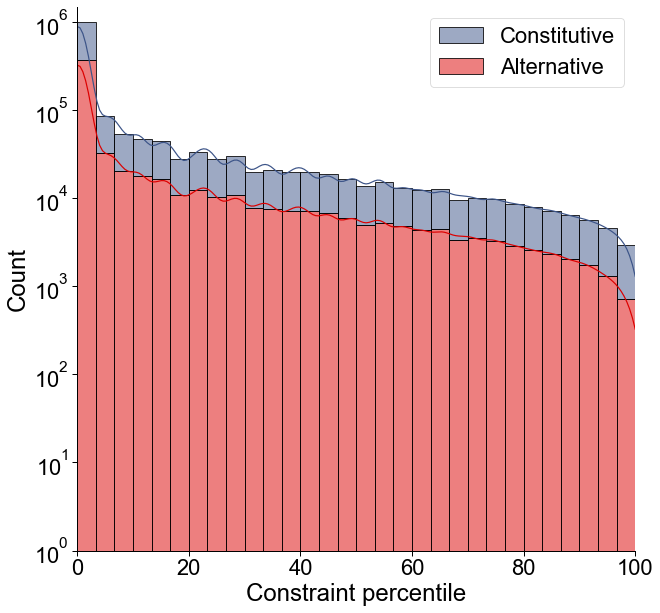

In [24]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

sns.set_context('paper', font_scale=2.5)

f, ax = plt.subplots(figsize=(10,10))
ax.set_axisbelow(True)

# plt.grid(True, axis='y')
p = sns.histplot(merge_df, x='CCRS_CCR_percentile', hue='Const_Alt', multiple="stack", bins=30, kde=True, ax=ax, palette=['#3C548899', '#DC000099'])
plt.yscale('log')

plt.ylim(bottom=1)
plt.xlim(left=0, right=100)
# ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.minorticks_off()
# ax.yaxis.label.set_size(12)
# plt.tick_params(axis = "x", which = "both", bottom = False, top = False)

# plt.ylabel('CCR count')
plt.xlabel('Constraint percentile')
legend = p.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")
# ax.text(-0.15, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')


In [38]:
# tmp_ccrs_path = '/home/weber/PycharmProjects/ExoCarto/data/2_processed/CCRS_modified.parquet'
tmp_ccrs_path = "/gstock/EXOTIC/data/VARIATIONS/CCRS_modified_refseq_corrected.parquet"
merge_df = pd.read_parquet(tmp_ccrs_path)
# merge_df = merge_df.drop(['CCR_0-20_bool', 'CCR_20-80_bool', 'CCR_80-90_bool', 'CCR_90-95_bool', 'CCR_95-99_bool', 'CCR_99-100_bool'], axis=1)
merge_df = merge_df.drop(['CCR_0_20_bool', 'CCR_20_80_bool', 'CCR_80_90_bool', 'CCR_90_95_bool', 'CCR_95_99_bool', 'CCR_99_100_bool'], axis=1)
bins = [0, 20, 80, 90, 95, 99, 100]
labels = bins.copy()
labels_ratio = [str(round(labels[j], 1)) + " - " + str(round(labels[j + 1], 1)) for j in range(len(labels) - 1)]
merge_df["CCRS_bins"] = pd.cut(merge_df["CCRS_CCR_percentile"], bins=bins, labels=labels_ratio, include_lowest=True)
merge_df[['Start' , 'Stop']] = merge_df.ranges.str.split('-', expand=True)
merge_df['Start'] = merge_df['Start'].astype(int)
merge_df['Stop'] = merge_df['Stop'].astype(int)
merge_df['Length'] = merge_df['Stop'] - merge_df['Start']
merge_df.loc[merge_df['CCRS_bins'] == '0 - 20', 'CCR_0_20_bool'] = True
merge_df.loc[merge_df['CCRS_bins'] == '20 - 80', 'CCR_20_80_bool'] = True
merge_df.loc[merge_df['CCRS_bins'] == '80 - 90', 'CCR_80_90_bool'] = True
merge_df.loc[merge_df['CCRS_bins'] == '90 - 95', 'CCR_90_95_bool'] = True
merge_df.loc[merge_df['CCRS_bins'] == '95 - 99', 'CCR_95_99_bool'] = True
merge_df.loc[merge_df['CCRS_bins'] == '99 - 100', 'CCR_99_100_bool'] = True
merge_df.loc[merge_df['CCRS_bins'].isin(['95 - 99', '99 - 100']), 'CCR_95_100_bool'] = True

merge_df.loc[merge_df['Ratio_num'] == 1, 'Constitutive'] = True
merge_df.loc[merge_df['Ratio_num'] < 1, 'Alternative'] = True
merge_df.loc[merge_df['Ratio_num'] < 1, 'Const_Alt'] = "Alt"
merge_df.loc[merge_df['Ratio_num'] == 1, 'Const_Alt'] = "Const"
merge_df.loc[(merge_df['Ratio_num'] < 1) & (merge_df['Ratio_num'] >= 0.8), 'Cat80100'] = True
merge_df.loc[(merge_df['Ratio_num'] < 0.8) & (merge_df['Ratio_num'] >= 0.6), 'Cat6080'] = True
merge_df.loc[(merge_df['Ratio_num'] < 0.6) & (merge_df['Ratio_num'] >= 0.4), 'Cat4060'] = True
merge_df.loc[(merge_df['Ratio_num'] < 0.4) & (merge_df['Ratio_num'] >= 0.2), 'Cat2040'] = True
merge_df.loc[(merge_df['Ratio_num'] < 0.2) & (merge_df['Ratio_num'] > 0), 'Cat0020'] = True
merge_df[['CCR_0_20_bool', 'CCR_20_80_bool', 'CCR_80_90_bool', 'CCR_90_95_bool', 'CCR_95_99_bool', 'CCR_99_100_bool', 'CCR_95_100_bool', 'Cat0020', 'Cat2040', 'Cat4060', 'Cat6080', 'Cat80100', 'Constitutive', 'Alternative']] = merge_df[['CCR_0_20_bool', 'CCR_20_80_bool', 'CCR_80_90_bool', 'CCR_90_95_bool', 'CCR_95_99_bool', 'CCR_99_100_bool', 'CCR_95_100_bool', 'Cat0020', 'Cat2040', 'Cat4060', 'Cat6080', 'Cat80100', 'Constitutive', 'Alternative']].fillna(False)
merge_df.to_parquet("/gstock/EXOTIC/data/VARIATIONS/CCRS_modified_refseq_corrected_Rdata.parquet")


merge_df
# merge_df = merge_df.loc[merge_df['CCRS_CCR_percentile'] > 0]

,Gene,RefSeq_Chrom,CCRS_ranges,CCRS_Start,CCRS_End,CCRS_CCR_percentile,Missing_coverage_bp,Gap_with_previous_CCRS,ranges,Ratio_num,...,CCRS_bins,Start,Stop,Length,CCR_0_20_bool,CCR_20_80_bool,CCR_80_90_bool,CCR_90_95_bool,CCR_95_99_bool,CCR_99_100_bool
0,A2M,12,9220421-9220435,9220421,9220435,94.960308,0.0,None,9220419-9220435,1.0,...,90 - 95,9220419,9220435,16,False,False,False,True,False,False
1,A2M,12,9220792-9220793,9220792,9220793,0.000000,0.0,None,9220779-9220820,1.0,...,0 - 20,9220779,9220820,41,True,False,False,False,False,False
2,A2M,12,9220793-9220810,9220793,9220810,72.870475,0.0,None,9220779-9220820,1.0,...,20 - 80,9220779,9220820,41,False,True,False,False,False,False
3,A2M,12,9220810-9220811,9220810,9220811,0.000000,0.0,None,9220779-9220820,1.0,...,0 - 20,9220779,9220820,41,True,False,False,False,False,False
4,A2M,12,9220811-9220820,9220811,9220820,96.319079,0.0,None,9220779-9220820,1.0,...,95 - 99,9220779,9220820,41,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605118,ZXDC,3,126194500-126194505,126194500,126194505,0.204138,0.0,None,126193802-126194708,1.0,...,0 - 20,126193802,126194708,906,True,False,False,False,False,False
1605119,ZXDC,3,126194505-126194506,126194505,126194506,0.000000,0.0,None,126193802-126194708,1.0,...,0 - 20,126193802,126194708,906,True,False,False,False,False,False
1605120,ZXDC,3,126194506-126194508,126194506,126194508,2.763944,0.0,None,126193802-126194708,1.0,...,0 - 20,126193802,126194708,906,True,False,False,False,False,False
1605121,ZXDC,3,126194508-126194509,126194508,126194509,0.000000,0.0,None,126193802-126194708,1.0,...,0 - 20,126193802,126194708,906,True,False,False,False,False,False


In [4]:
# tmp_clinvar_ccrs_path = '/home/weber/PycharmProjects/ExoCarto/data/2_processed/ClinVar_CCRS_modified.parquet'
tmp_clinvar_ccrs_path = '/gstock/EXOTIC/data/VARIATIONS/ClinVar_CCRS_gnomAD.parquet'
tmp_clinvar_ccrs_path = "/gstock/EXOTIC/data/VARIATIONS/ClinVar_CCRS_gnomAD_2021_refseq_corrected.parquet"
merge_ccrs_variants = pd.read_parquet(tmp_clinvar_ccrs_path)
# merge_ccrs_variants = merge_ccrs_variants.head(10000)

merge_ccrs_variants = merge_ccrs_variants.loc[merge_ccrs_variants['Status'] != 'Other']
path_genes = list(merge_ccrs_variants.loc[merge_ccrs_variants['Status'] == 'Pathogenic'].Gene.unique())
merge_ccrs_variants = merge_ccrs_variants.loc[merge_ccrs_variants['Gene'].isin(path_genes)]
merge_ccrs_variants.loc[merge_ccrs_variants['Status'] == 'Benign' , 'Benign'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['Status'] == 'Pathogenic' , 'Pathogenic'] = True
merge_ccrs_variants[['Benign', 'Pathogenic']] = merge_ccrs_variants[['Benign', 'Pathogenic']].fillna(False)
merge_ccrs_variants.loc[merge_ccrs_variants['Ratio_num'] == 1, 'Constitutive'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['Ratio_num'] < 1, 'Alternative'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['Ratio_num'] < 1, 'Const_Alt'] = "Alt"
merge_ccrs_variants.loc[merge_ccrs_variants['Ratio_num'] == 1, 'Const_Alt'] = "Const"
merge_ccrs_variants.loc[(merge_ccrs_variants['Ratio_num'] < 1) & (merge_ccrs_variants['Ratio_num'] >= 0.8), 'Cat80100'] = True
merge_ccrs_variants.loc[(merge_ccrs_variants['Ratio_num'] < 0.8) & (merge_ccrs_variants['Ratio_num'] >= 0.6), 'Cat6080'] = True
merge_ccrs_variants.loc[(merge_ccrs_variants['Ratio_num'] < 0.6) & (merge_ccrs_variants['Ratio_num'] >= 0.4), 'Cat4060'] = True
merge_ccrs_variants.loc[(merge_ccrs_variants['Ratio_num'] < 0.4) & (merge_ccrs_variants['Ratio_num'] >= 0.2), 'Cat2040'] = True
merge_ccrs_variants.loc[(merge_ccrs_variants['Ratio_num'] < 0.2) & (merge_ccrs_variants['Ratio_num'] > 0), 'Cat0020'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['CCRS_bins'] == '0 - 20', 'CCR_0_20_bool'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['CCRS_bins'] == '20 - 80', 'CCR_20_80_bool'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['CCRS_bins'] == '80 - 90', 'CCR_80_90_bool'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['CCRS_bins'] == '90 - 95', 'CCR_90_95_bool'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['CCRS_bins'] == '95 - 99', 'CCR_95_99_bool'] = True
merge_ccrs_variants.loc[merge_ccrs_variants['CCRS_bins'] == '99 - 100', 'CCR_99_100_bool'] = True

# merge_ccrs_variants['MC'] = merge_ccrs_variants['MC'].apply(lambda r: eval(r) if '[' in r else r)
# merge_ccrs_variants['MC'] = merge_ccrs_variants['MC'].apply(lambda r: list(set(r)))
# merge_ccrs_variants = merge_ccrs_variants.explode('MC')
merge_ccrs_variants[['CCR_0_20_bool', 'CCR_20_80_bool', 'CCR_80_90_bool', 'CCR_90_95_bool', 'CCR_95_99_bool', 'CCR_99_100_bool', 'Cat0020', 'Cat2040', 'Cat4060', 'Cat6080', 'Cat80100', 'Constitutive', 'Alternative']] = merge_ccrs_variants[['CCR_0_20_bool', 'CCR_20_80_bool', 'CCR_80_90_bool', 'CCR_90_95_bool', 'CCR_95_99_bool', 'CCR_99_100_bool', 'Cat0020', 'Cat2040', 'Cat4060', 'Cat6080', 'Cat80100', 'Constitutive', 'Alternative']].fillna(False)
print(list(merge_ccrs_variants.columns))

# merge_ccrs_variants.to_parquet('/gstock/EXOTIC/data/VARIATIONS/Variants_CCRS_Rdata.parquet', index=False)
path_genes = list(merge_ccrs_variants.loc[merge_ccrs_variants['Status'] == 'Pathogenic'].Gene.unique())
merge_ccrs_variants = merge_ccrs_variants.loc[merge_ccrs_variants['Gene'].isin(path_genes)]
merge_ccrs_variants


['ALT', 'AN', 'CHROM', 'CLNREVSTAT', 'DP', 'Gene', 'HPO', 'ID', 'MAF', 'MC', 'POS', 'REF', 'RS_STARS', 'Real_Status', 'Status', 'VAR_ID', 'alleleid', 'ranges', 'rs', 'Ratio_num', 'Const_Alt', 'Ratio_num_bins', 'CCRS_ranges', 'CCRS_bins', 'CCRS_CCR_percentile', 'Benign', 'Pathogenic', 'Constitutive', 'Alternative', 'Cat80100', 'Cat6080', 'Cat4060', 'Cat2040', 'Cat0020', 'CCR_0_20_bool', 'CCR_20_80_bool', 'CCR_80_90_bool', 'CCR_90_95_bool', 'CCR_95_99_bool', 'CCR_99_100_bool']


,ALT,AN,CHROM,CLNREVSTAT,DP,Gene,HPO,ID,MAF,MC,...,Cat6080,Cat4060,Cat2040,Cat0020,CCR_0_20_bool,CCR_20_80_bool,CCR_80_90_bool,CCR_90_95_bool,CCR_95_99_bool,CCR_99_100_bool
656,A,251238.0,10,None,9602714.0,ACTA2,None,10_90694983_G_A,0.000016,"['synonymous_variant', 'synonymous_variant']",...,False,False,False,False,False,True,False,False,False,False
657,G,251272.0,10,None,9618869.0,ACTA2,None,10_90695002_A_G,0.000016,"['missense_variant', 'missense_variant']",...,False,False,False,False,True,False,False,False,False,False
658,G,251272.0,10,None,9618869.0,ACTA2,None,10_90695002_A_G,0.000016,"['missense_variant', 'missense_variant']",...,False,False,False,False,True,False,False,False,False,False
659,C,251242.0,10,None,9619772.0,ACTA2,None,10_90695005_G_C,0.000008,"['missense_variant', 'missense_variant']",...,False,False,False,False,True,False,False,False,False,False
660,C,251242.0,10,None,9619772.0,ACTA2,None,10_90695005_G_C,0.000008,"['missense_variant', 'missense_variant']",...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028212,T,250968.0,2,None,9556254.0,TTN,None,2_179669352_C_T,0.000012,"['synonymous_variant', 'synonymous_variant', '...",...,False,False,False,False,True,False,False,False,False,False
1028213,A,250928.0,2,None,9553535.0,TTN,None,2_179669353_G_A,0.000012,"['missense_variant', 'missense_variant', 'miss...",...,False,False,False,False,True,False,False,False,False,False
1028214,A,250928.0,2,None,9553535.0,TTN,None,2_179669353_G_A,0.000012,"['missense_variant', 'missense_variant', 'miss...",...,False,False,False,False,True,False,False,False,False,False
1028215,T,250908.0,2,None,9542747.0,TTN,None,2_179669357_C_T,0.000143,"['missense_variant', 'missense_variant', 'miss...",...,False,False,False,False,True,False,False,False,False,False


,ALT,AN,CHROM,CLNREVSTAT,DP,Gene,ID,MAF,MC,POS,...,VAR_ID,alleleid,ranges,rs,Ratio_num,Const_Alt,Ratio_num_bins,CCRS_ranges,CCRS_bins,CCRS_CCR_percentile
656,A,251238.0,10,None,9602714.0,ACTA2,10_90694983_G_A,0.000016,"['synonymous_variant', 'synonymous_variant']",90694983.0,...,None,NaN,90694980-90695123,rs1062399,1.0,Const,0.8 - 1,90694982-90694993,20 - 80,66.594394
657,G,251272.0,10,None,9618869.0,ACTA2,10_90695002_A_G,0.000016,"['missense_variant', 'missense_variant']",90695002.0,...,None,NaN,90694980-90695123,rs778887472,1.0,Const,0.8 - 1,90695001-90695002,0 - 20,0.000000
658,G,251272.0,10,None,9618869.0,ACTA2,10_90695002_A_G,0.000016,"['missense_variant', 'missense_variant']",90695002.0,...,None,NaN,90694980-90695123,rs778887472,1.0,Const,0.8 - 1,90695002-90695004,0 - 20,7.530829
659,C,251242.0,10,None,9619772.0,ACTA2,10_90695005_G_C,0.000008,"['missense_variant', 'missense_variant']",90695005.0,...,None,NaN,90694980-90695123,rs749867078,1.0,Const,0.8 - 1,90695004-90695005,0 - 20,0.000000
660,C,251242.0,10,None,9619772.0,ACTA2,10_90695005_G_C,0.000008,"['missense_variant', 'missense_variant']",90695005.0,...,None,NaN,90694980-90695123,rs749867078,1.0,Const,0.8 - 1,90695005-90695007,0 - 20,7.530829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028212,T,250968.0,2,None,9556254.0,TTN,2_179669352_C_T,0.000012,"['synonymous_variant', 'synonymous_variant', '...",179669352.0,...,None,NaN,179669279-179669369,rs755302800,1.0,Const,0.8 - 1,179669352-179669353,0 - 20,0.000000
1028213,A,250928.0,2,None,9553535.0,TTN,2_179669353_G_A,0.000012,"['missense_variant', 'missense_variant', 'miss...",179669353.0,...,None,NaN,179669279-179669369,rs201490999,1.0,Const,0.8 - 1,179669352-179669353,0 - 20,0.000000
1028214,A,250928.0,2,None,9553535.0,TTN,2_179669353_G_A,0.000012,"['missense_variant', 'missense_variant', 'miss...",179669353.0,...,None,NaN,179669279-179669369,rs201490999,1.0,Const,0.8 - 1,179669353-179669355,0 - 20,6.169916
1028215,T,250908.0,2,None,9542747.0,TTN,2_179669357_C_T,0.000143,"['missense_variant', 'missense_variant', 'miss...",179669357.0,...,None,NaN,179669279-179669369,rs552620474,1.0,Const,0.8 - 1,179669356-179669357,0 - 20,0.000000


232225 3413 81516 4483
69947 3040 243794 4856
6546 579 307195 7317
2848 336 310893 7560
1665 377 312076 7519
510 151 313231 7745
276037 4469 106864 6101
88268 3973 294633 6597
9555 794 373346 9776
4562 485 378339 10085
3640 661 379261 9909
839 188 382062 10382
Legend
Rectangle(xy=(-0.4, 1), width=0.4, height=0.283579, angle=0)
0.28357860187872963
Rectangle(xy=(0.6, 1), width=0.4, height=2.01025, angle=0)
2.0102505169825418
Rectangle(xy=(1.6, 1), width=0.4, height=3.17351, angle=0)
3.17351182447044
Rectangle(xy=(2.6, 1), width=0.4, height=3.98834, angle=0)
3.98833533987846
Rectangle(xy=(3.6, 1), width=0.4, height=6.95038, angle=0)
6.950378138865877
Rectangle(xy=(4.6, 1), width=0.4, height=8.2461, angle=0)
8.246102117238303
Rectangle(xy=(-2.77556e-17, 1), width=0.4, height=0.26724, angle=0)
0.2672399848741387
Rectangle(xy=(1, 1), width=0.4, height=2.18197, angle=0)
2.1819702557094947
Rectangle(xy=(2, 1), width=0.4, height=3.7135, angle=0)
3.713501899760825
Rectangle(xy=(3, 1), width=0.4,

Const_Alt                Alt   Const
CCRS_bins Status                    
0 - 20    Benign      232225  276037
          Pathogenic    3413    4469
20 - 80   Benign       69947   88268
          Pathogenic    3040    3973
80 - 90   Benign        6546    9555
          Pathogenic     579     794
90 - 95   Benign        2848    4562
          Pathogenic     336     485
95 - 99   Benign        1665    3640
          Pathogenic     377     661
99 - 100  Benign         510     839
          Pathogenic     151     188

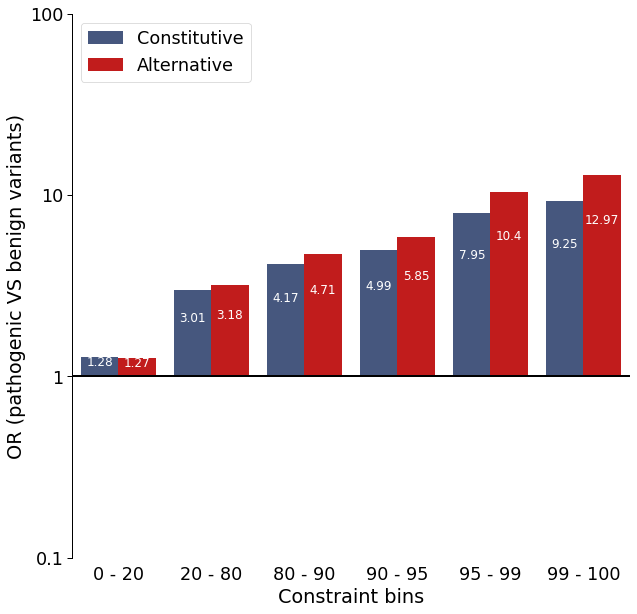

In [13]:
def show_values_on_bars(axs, i=0, fontsize=10, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            print(p.get_height())
            if p.get_height() >= 1:
                _y = p.get_y() + (p.get_height() / 2)
            elif p.get_height() < 1:
                _y = p.get_y() + (p.get_height() / 2) + p.get_height() * 0.005
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(float(value) + 1, 2)), ha="center", fontsize=fontsize, rotation=rotation, color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

d = pd.pivot_table(merge_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins']).size().reset_index(), index=['CCRS_bins', 'Status'], columns='Const_Alt', values=0)
# d = pd.pivot_table(merge_ccrs_variants.groupby(['Const_Alt', 'Status', 'CCRS_bins']).size().reset_index(), index=['CCRS_bins', 'Const_Alt'], columns='Status', values=0)
d

new_d = collections.defaultdict(dict)
for k in d.to_dict():
    new_d[k] = dict()
    for sub_k, v in d[k].items():
        if sub_k[0] not in new_d[k]:
            new_d[k][sub_k[0]] = dict()
        new_d[k][sub_k[0]][sub_k[1]] = v
odr_alt = list()
odr_const = list()
labels = list(new_d['Alt'].keys())

l = list()



new_d
        
for const_alt in new_d:
    for ccr in new_d[const_alt]:
        b = new_d[const_alt][ccr]['Benign']
        p = new_d[const_alt][ccr]['Pathogenic']
        other_b = sum([new_d[const_alt][e]['Benign'] for e in labels if new_d[const_alt][e]['Benign'] != b])
        other_p= sum([new_d[const_alt][e]['Pathogenic'] for e in labels if new_d[const_alt][e]['Pathogenic'] != p])
        print(b, p, other_b, other_p)
        odr = ((p / b) / (other_p / other_b))
#         print(const_alt, ccr, odr)
        l.append(
            {
                'Const_Alt' : const_alt,
                'CCRS_bins' : ccr,
                'ODR' : odr,
            }        
        )

t = pd.DataFrame(l)
# t['ODR'] = t['ODR'] - 1
# t

f, ax = plt.subplots(figsize=(10,10))
sns.set_context('paper',  font_scale=2)

ax.set_axisbelow(True)
# ax.grid(True, axis='y')
p = sns.barplot(data=t.sort_values(by='Const_Alt', ascending=False), x='CCRS_bins', y='ODR', hue='Const_Alt', bottom=1, zorder=1, palette=['#3C5488FF', '#DC000099'])
plt.yscale('log')
# plt.xticks(rotation=45)
plt.xlabel('Constraint bins')
plt.ylabel('OR (pathogenic VS benign variants)')
ax.legend(loc='upper left')
legend = ax.get_legend()
legend.set_title('')
legend.texts[0].set_text("Constitutive")
legend.texts[1].set_text("Alternative")
print(legend)
# ax.legend(loc='upper left')
show_values_on_bars(ax, i=2, fontsize=12)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
ax.set_yticks([0.1, 1, 10, 100, ], )
ax.set_ylim(0.1, 100)
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.minorticks_off()
plt.axhline(1, lw=2, color='black', zorder=2)
# ax.text(-0.2, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.spines['bottom'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
# plt.yscale('symlog')
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+1))
# ax.set_yticklabels([1,'', 10])
# yticks = ax.yaxis.get_major_ticks()
# yticks[1].set_visible(False)
# plt.yticks([1, 10])

# plt.ylim(0, )
d